In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import tensorflow as tf
from os import path, remove
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph, renderStatsList, renderStatsCollection, \
    renderStatsListWithLabels, renderStatsCollectionOfCrossValids, plot_res_gp, my_plot_convergence
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common_33 import get_or_run_nn
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import matplotlib.cm as cm
import sys
import matplotlib  as mpl
from models.model_34_price_history_autoencoder import PriceHistoryAutoencoder
from data_providers.data_provider_33_price_history_autoencoder import PriceHistoryAutoEncDataProvider
#from gp_opt.price_history_27_gp_opt import PriceHistoryGpOpt

/home/student/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
n_jobs = 1
%matplotlib inline
mpl.rc('figure', figsize=(17,7)) #setting the default value of figsize for our plots
#https://matplotlib.org/users/customizing.html

### Step 0 - hyperparams

In [4]:
factors(689)

[1, 53, 13, 689]

In [5]:
max_seq_len = 682

In [6]:
data_path = '../../../../Dropbox/data'

In [7]:
phae_path = data_path + '/price_hist_autoencoder'

In [8]:
npz_dates = phae_path + '/price_history_full_seqs_dates.npz'
assert path.isfile(npz_dates)

In [9]:
npz_train = phae_path + '/price_history_seqs_dates_normed_train.npz'
assert path.isfile(npz_train)

In [10]:
npz_test = phae_path + '/price_history_seqs_dates_normed_test.npz'
assert path.isfile(npz_test)

In [11]:
npz_path = npz_train[:-len('_train.npz')]

In [12]:
for key, val in np.load(npz_train).iteritems():
    print key, ",", val.shape

inputs , (689, 682, 7)
sku_ids , (689,)
sequence_masks , (689, 682)
extra_inputs , (689, 682, 6)
sequence_lengths , (689,)


### Step 1 - collect data

In [13]:
# dp = PriceHistoryAutoEncDataProvider(npz_path=npz_path, batch_size=53, with_EOS=False)
# for data in dp.datalist:
#     print data.shape

(689, 682, 7)  
(689, 682, 6)  
(689,)  
(689, 682)

In [14]:
# for item in dp.next():
#     print item.shape

### Step 2 - Build model

In [15]:
# model = PriceHistoryAutoencoder(rng=random_state, dtype=dtype, config=config)
# graph = model.getGraph(batch_size=53,
                       
#                        #the way we have it these two must be equal for now
#                        enc_num_units = 10,
#                        hidden_enc_num_units = 10,
                       
#                        hidden_enc_dim = 12,
#                        hidden_dec_dim = 13,
                       
#                        #the way we have it these two must be equal for now
#                        hidden_dec_num_units = 14,
#                        dec_num_units = 14,
                       
#                        ts_len=max_seq_len)

targets
Tensor("data/strided_slice:0", shape=(53, 682), dtype=float32)

Tensor("encoder_rnn_layer/rnn/transpose:0", shape=(53, 682, 10), dtype=float32)
Tensor("encoder_rnn_layer/rnn/while/Exit_2:0", shape=(?, 10), dtype=float32)

Tensor("hidden_encoder_rnn_layer/rnn/transpose:0", shape=(53, 682, 10), dtype=float32)
Tensor("hidden_encoder_rnn_layer/rnn/while/Exit_2:0", shape=(?, 10), dtype=float32)

Tensor("encoder_state_out_hidden_process/Elu:0", shape=(?, 12), dtype=float32)

Tensor("encoder_state_out_process/Elu:0", shape=(?, 2), dtype=float32)

Tensor("decoder_state_in_hidden_process/Elu:0", shape=(?, 13), dtype=float32)

Tensor("decoder_state_in_process/Elu:0", shape=(?, 14), dtype=float32)

Tensor("hidden_decoder_rnn_layer/rnn/transpose:0", shape=(53, 682, 14), dtype=float32)
Tensor("hidden_decoder_rnn_layer/rnn/while/Exit_2:0", shape=(?, 14), dtype=float32)

Tensor("decoder_rnn_layer/rnn/transpose:0", shape=(53, 682, 14), dtype=float32)
Tensor("decoder_rnn_layer/rnn/while/Exit_2:0", shape=(?, 14), dtype=float32)

Tensor("decoder_outs/Reshape:0", shape=(36146, 14), dtype=float32)

Tensor("readout_affine/Identity:0", shape=(36146, 1), dtype=float32)
Tensor("readout_affine/Reshape:0", shape=(53, 682), dtype=float32)

Tensor("error/mul_1:0", shape=(53, 682), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)
Tensor("error/Mean:0", shape=(), dtype=float32)

In [16]:
#show_graph(graph)

### Step 3 training the network

In [17]:
nn_runs_folder = data_path + '/nn_runs'
filepath = nn_runs_folder + '/034_autoencoder_000.npz'
assert path.isfile(filepath), "we are not training, we are only loading the experiment here"

In [18]:
dyn_stats, preds_dict, targets, twods = get_or_run_nn(callback=None, filename='034_autoencoder_000',
                                                      nn_runs_folder = data_path + "/nn_runs")

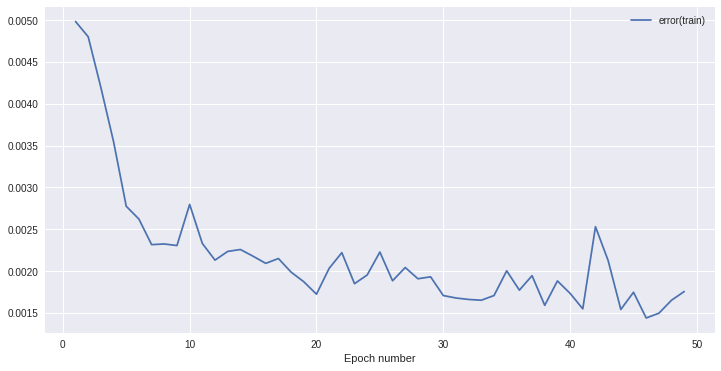

In [19]:
dyn_stats.plotStats()
plt.show()

In [20]:
r2_scores = [r2_score(y_true=targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(targets))]

In [21]:
ind = np.argmin(r2_scores)
ind

306

In [22]:
reals = targets[ind]
preds = preds_dict[ind]

In [23]:
r2_score(y_true=reals, y_pred=preds)

-3334369.5627183039

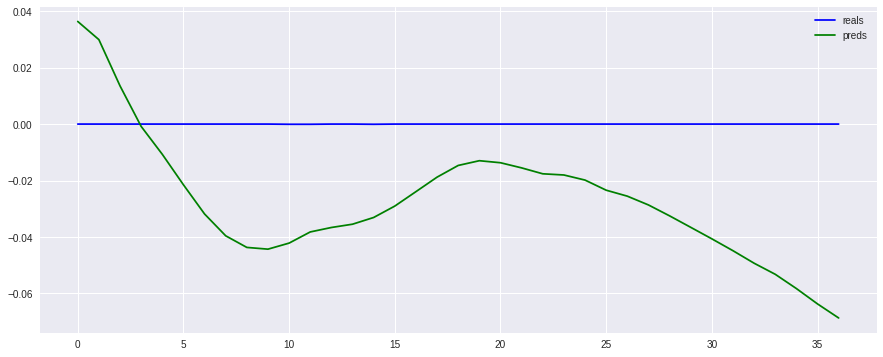

In [24]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [25]:
%%time
dtw_scores = [fastdtw(targets[ind], preds_dict[ind])[0]
             for ind in range(len(targets))]

CPU times: user 11.4 s, sys: 48 ms, total: 11.5 s
Wall time: 11.5 s


In [26]:
np.mean(dtw_scores)

10.986209263876011

In [27]:
coint(preds, reals)

(-0.39427384187674469,
 0.97106180497021621,
 array([-4.22652904, -3.51111966, -3.16435988]))

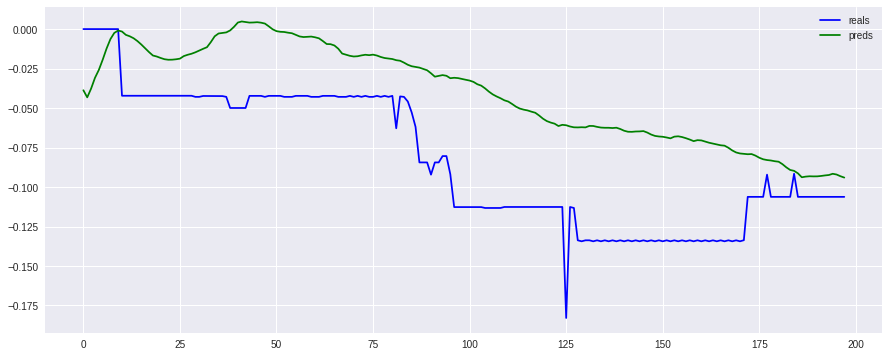

In [28]:
cur_ind = np.random.randint(len(targets))
reals = targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b', label='reals')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

### Conclusion
The autoencoder is not able to represent in a visibly obvious way our price history time series

# TS in Two Dimensions

In [29]:
twod_arr = np.array(twods.values())
twod_arr.shape

(689, 2)

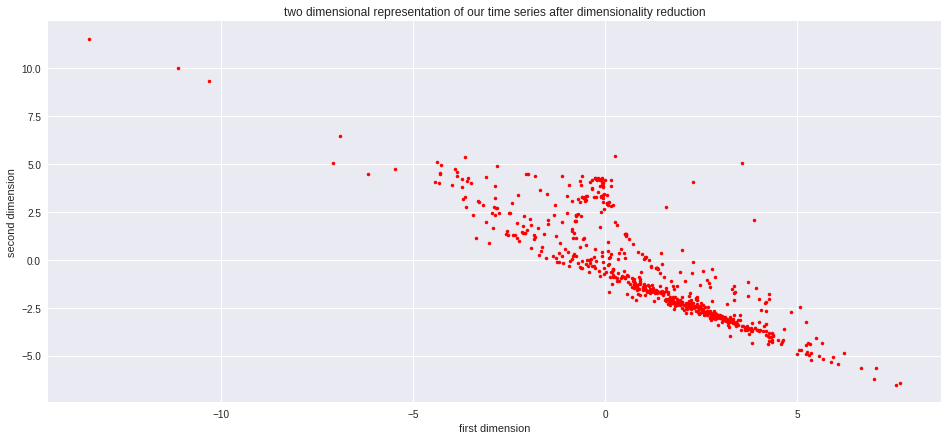

In [30]:
plt.figure(figsize=(16,7))
plt.plot(twod_arr[:, 0], twod_arr[:, 1], 'r.')
plt.title('two dimensional representation of our time series after dimensionality reduction')
plt.xlabel('first dimension')
plt.ylabel('second dimension')
plt.show()

# K-means clustering

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [32]:
km = KMeans(init='random', #init='k-means++',
            n_clusters=3, n_init=10)

In [33]:
km.fit(twod_arr)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [34]:
km.inertia_

2045.2348755532837

In [35]:
silhouette_score(twod_arr, km.labels_)

0.50380160003484875

In [36]:
def getKmeansScores():
    for kk in range(2, 20):
        km = KMeans(init='random', #init='k-means++',
                n_clusters=kk, n_init=100).fit(twod_arr)
        score = silhouette_score(twod_arr, km.labels_)
        yield kk, score

In [37]:
%%time
dic = OrderedDict(list(getKmeansScores()))

CPU times: user 14.2 s, sys: 9.33 s, total: 23.5 s
Wall time: 13 s


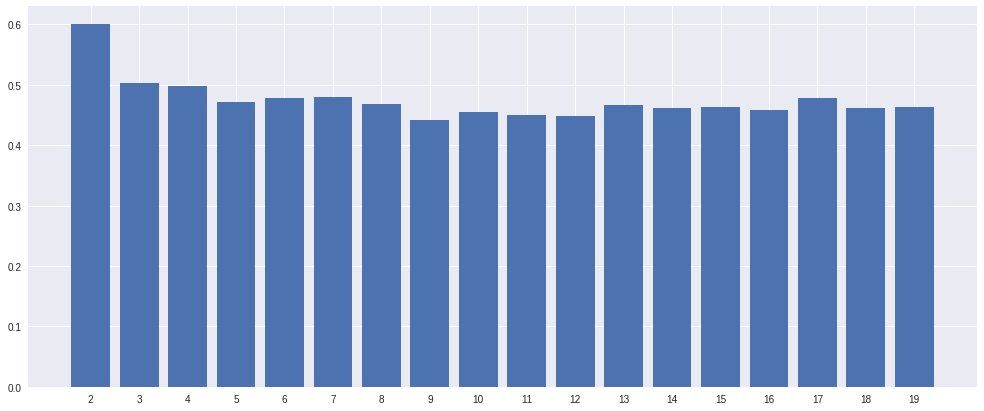

In [38]:
plt.bar(dic.keys(), dic.values())
plt.xticks(dic.keys())
plt.show()

In [39]:
from mylibs.kde_2d_label import kde_2d_label

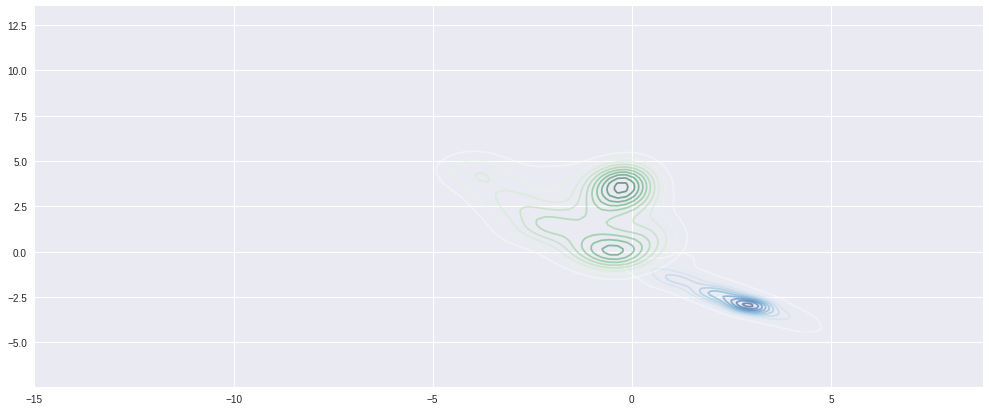

In [40]:
km = KMeans(init='random', #init='k-means++',
                n_clusters=2, n_init=100).fit(twod_arr)
kde_2d_label(twod_arr, km.labels_)

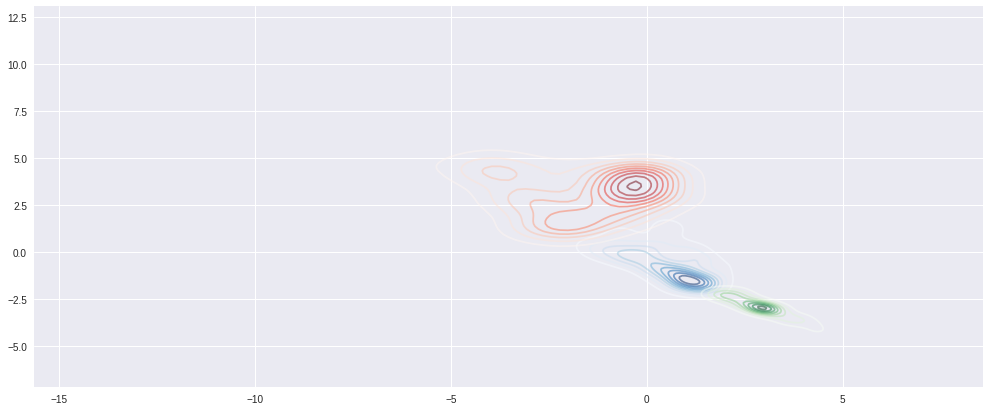

In [41]:
kde_2d_label(twod_arr, KMeans(init='random', n_clusters=3, n_init=100).fit(twod_arr).labels_)

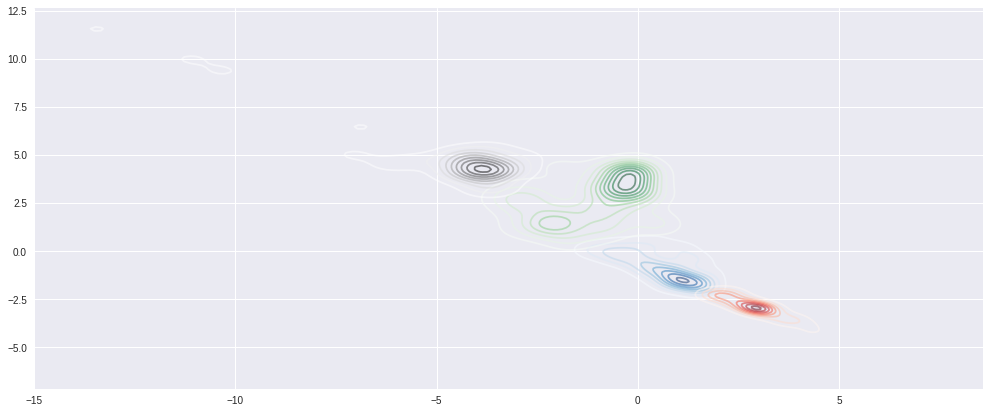

In [42]:
kde_2d_label(twod_arr, KMeans(init='random', n_clusters=4, n_init=100).fit(twod_arr).labels_)

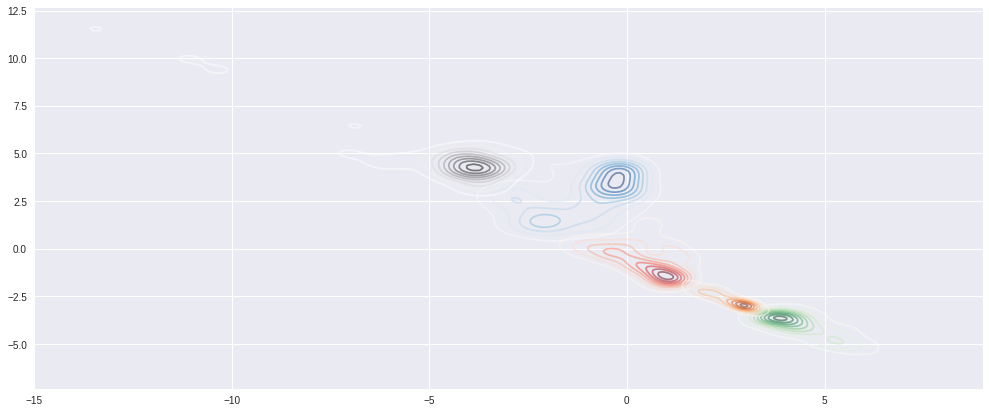

In [43]:
kde_2d_label(twod_arr, KMeans(init='random', n_clusters=5, n_init=100).fit(twod_arr).labels_)

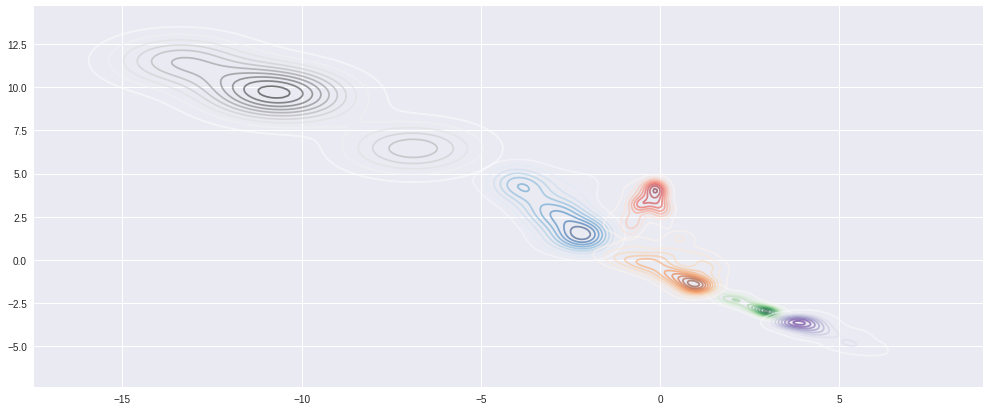

In [44]:
kde_2d_label(twod_arr, KMeans(init='random', n_clusters=6, n_init=100).fit(twod_arr).labels_)

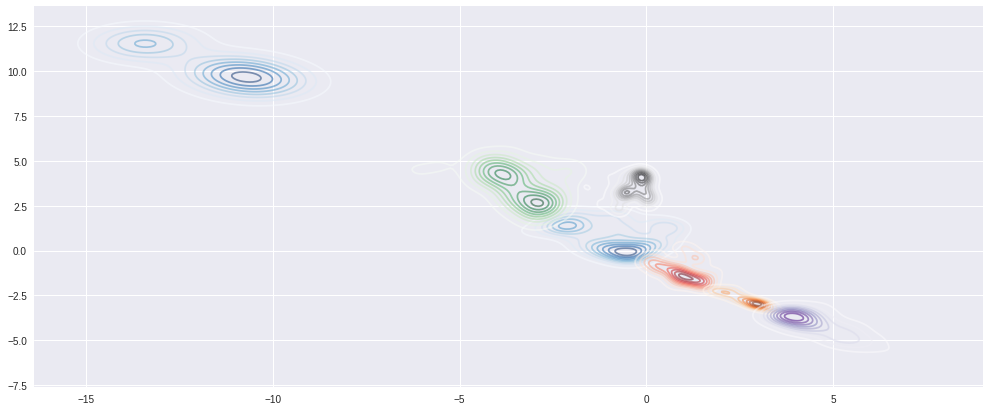

In [45]:
kde_2d_label(twod_arr, KMeans(init='random', n_clusters=7, n_init=100).fit(twod_arr).labels_)

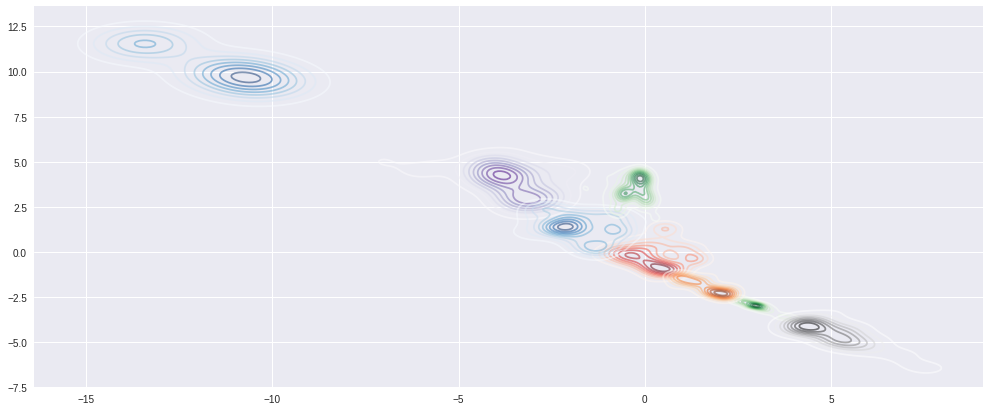

In [46]:
kde_2d_label(twod_arr, KMeans(init='random', n_clusters=8, n_init=100).fit(twod_arr).labels_)

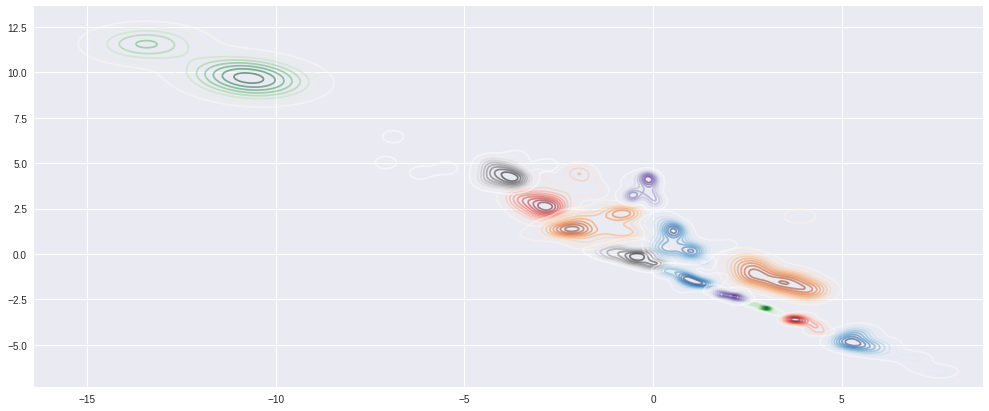

In [47]:
kde_2d_label(twod_arr, KMeans(init='random', n_clusters=13, n_init=100).fit(twod_arr).labels_)

### Conclusion
Visually it SEEMS meaningful to have six(6) clusters. But this is a very big if. However this will help us segment our dataset a little bit and actual have the overhead that we are training six(6) different models!

If we want to split them further then 13 groups seems good enough

# Storing Groups of SKU ids

In [111]:
chosen_kk = 10

In [112]:
labels = KMeans(init='random', n_clusters=chosen_kk, n_init=100).fit(twod_arr).labels_

In [113]:
labels.shape

(689,)

In [114]:
assert np.all(preds_dict.keys() == np.arange(len(preds_dict))), \
    "just make sure that the order of the predictions and other outputs are in order"
#since order is not shuffled this simplifies things

In [115]:
assert path.isfile(npz_test)

In [116]:
sku_ids = np.load(npz_test)['sku_ids']
sku_ids.shape

(689,)

In [117]:
sku_dic = OrderedDict()
for ii in range(chosen_kk):
    sku_dic[str(ii)] = sku_ids[labels == ii]

In [118]:
assert np.sum([len(val) for val in sku_dic.values()]) == len(sku_ids), "weak check to ensure every item is assigned"

In [119]:
sku_ids_groups_path = data_path + '/sku_ids_groups'
assert path.isdir(sku_ids_groups_path)
path.abspath(sku_ids_groups_path)

'/home/student/Dropbox/data/sku_ids_groups'

In [120]:
sku_dic.keys()

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [121]:
for key, val in sku_dic.iteritems():
    print key, ",", val.shape

0 , (50,)
1 , (57,)
2 , (3,)
3 , (109,)
4 , (32,)
5 , (102,)
6 , (24,)
7 , (79,)
8 , (79,)
9 , (154,)


In [123]:
npz_sku_ids_group_kmeans = sku_ids_groups_path + '/sku_ids_kmeans_{:02d}.npz'.format(chosen_kk)
np.savez(npz_sku_ids_group_kmeans, **sku_dic)